## Exp5.2_Senariowise_CompvsIncomp_Push_Ch4

Author : @leopauly | cnlp@leeds.ac.uk <br>
Program: Tying to show that the proposed activity feature method can distinguish between complete vs Incomplete actions scenario by scenario

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import skimage
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.color import grey2rgb,rgb2grey
from skimage.feature import hog
from skimage import io

# Custom scripts
import lscript as lsp
import modelling as md

In [2]:
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [3]:
height=112 
width=112 
channel=3
crop_size=112
cluster_length=16
feature_size=8192 #4096 #16384
baseline_feature_size=4608
baseline2_feature_size=2
demo_num=1

nb_activities=4
nb_videos=5
nb_pixels_per_cell=(8,8)
nb_cells_per_block=(1,1)
nb_orientations=16
saved_path='/nobackup/leopauly/'
dataset_dir='/nobackup/leopauly/S2l/Dataset/Ch4/Leeds_dataset_Demowise_compvsincomp/push_frames/'

### Acitivity net

#### Defining model

In [4]:
## Defining placeholders in tf for images and targets
x_image = tf.placeholder(tf.float32, [None, 16,height,width,channel],name='x') 

model_keras = md.C3D_ucf101_training_model_tf(summary=False)
out=model_keras(x_image)

/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:281: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, (3, 3, 3), activation="relu", name="conv1", input_shape=(16, 112, ..., padding="same")`
  input_shape=input_shape))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:283: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid")`
  border_mode='valid', name='pool1'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:286: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(128, (3, 3, 3), activation="relu", name="conv2", padding="same")`
  border_mode='same', name='conv2'))
/home/home01/cnlp/Seeing_to_Learn/Observation-Learning/ExperimentSet_RA-L/modelling.py:288: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_si

#### Starting a session - Activity Net

In [5]:
#### Start the session with logging placement.
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))

### Restore model weights from previously saved model
saver = tf.train.Saver()
saver.restore(sess, os.path.join(saved_path,'activity_model.ckpt-67'))
print("Model restored from file: %s" % saved_path,flush=True)

INFO:tensorflow:Restoring parameters from /nobackup/leopauly/activity_model.ckpt-67
Model restored from file: /nobackup/leopauly/


In [6]:
## Extraction of features - Acitvity net
def extract_activitynet_video_features(vid):
    print('vid.shape',vid.shape)
    vid_=vid.reshape(-1,cluster_length,height,width,channel)
    f_v = sess.graph.get_tensor_by_name('flatten_1/Reshape:0')
    f_v_val=sess.run([f_v], feed_dict={'conv1_input:0':vid_,x_image:vid_,K.learning_phase(): 0 })
    features=np.reshape(f_v_val,(-1))
    return features

In [7]:
def get_compress_frames_data(vid_folder, num_frames_per_clip=cluster_length):
  ''' Given a foler with frames from a video, fuction outputs a  num_frames_per_clip images which is the downsampled video'''

  ret_arr = []
  filenames=os.listdir(vid_folder)
  filenames = sorted(filenames)
  jump=math.floor((len(filenames)/num_frames_per_clip))
  loop=0
  for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(vid_folder) + '/' + str(filenames[i])
        img = skimage.io.imread(image_name)  #Image.open
        img=np.array(img)
        img = cv2.resize(img,(crop_size,crop_size))
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  print('ret_arr',ret_arr.shape)
  return np.array(ret_arr)

In [8]:
## Extracting activity features from demo video
def activity_feature_extractor(folder):
    vid_folder=dataset_dir+folder
    print('Is the folder present:',os.path.isdir(vid_folder))
    temp_vid=get_compress_frames_data(vid_folder)
    print('Obtained video shape',temp_vid.shape)
    lsp.single_video_inline(temp_vid,0,cluster_length)
    activitynet_features=extract_activitynet_video_features(temp_vid)
    activitynet_features=np.array(activitynet_features)
    return activitynet_features

#### Rewards


In [154]:
distance_comp=[]
distance_incomp=[]
demo_folders=['','push_demo_0deg','push_demo_180deg','push_robo_arbview1','push_robo_sideview','push_robo_green','push_robo_obj2_new','push_robo_change_pos','push_robo_changetarget','push_robo_bg_fast','push_demo_human','push_robo_M2','push_robo_M3']
print('Total number of Demo folders',len(demo_folders))
print('Demo_folder loaded:',demo_folders[demo_num],demo_num)



Total number of Demo folders 13
Demo_folder loaded: push_robo_M3 12


Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


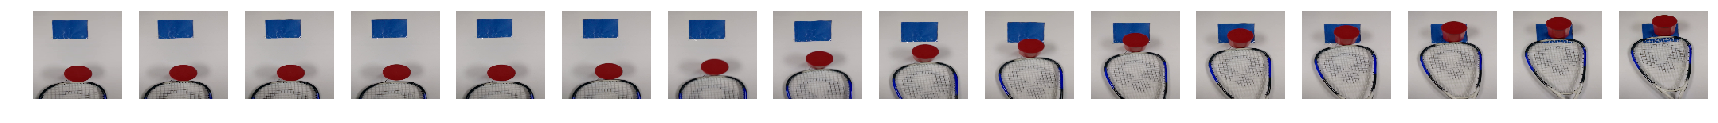

vid.shape (16, 112, 112, 3)


In [155]:
## Demo
activitynet_features_demo=(activity_feature_extractor(demo_folders[demo_num])) # Demo

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


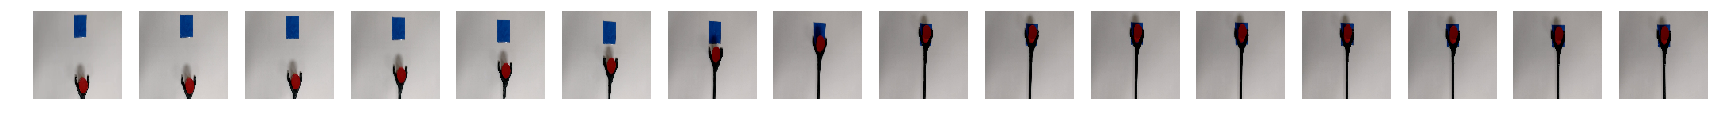

vid.shape (16, 112, 112, 3)
317.049


In [156]:
## Same speed
activitynet_features=(activity_feature_extractor('push_robo_fast')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_comp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


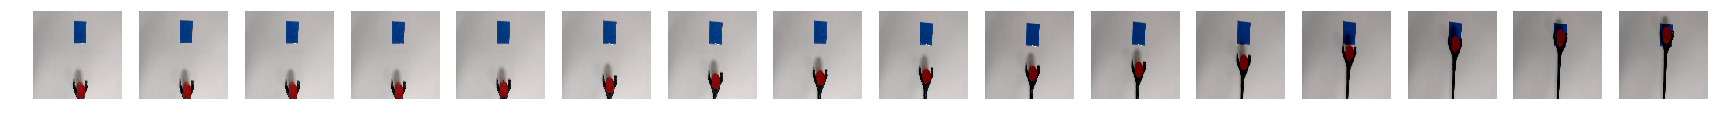

vid.shape (16, 112, 112, 3)
342.705


In [157]:
## Different speed
activitynet_features=(activity_feature_extractor('push_robo')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_comp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


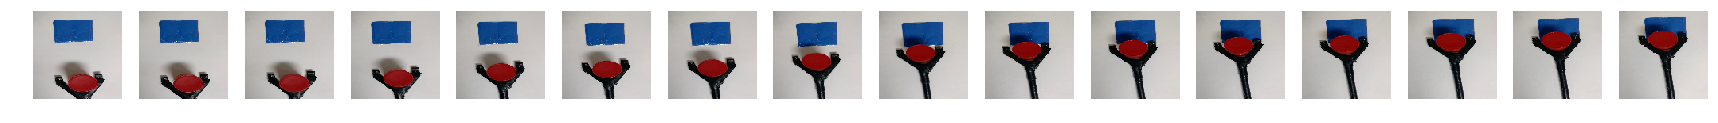

vid.shape (16, 112, 112, 3)
314.839


In [158]:
## Comp1
activitynet_features=(activity_feature_extractor('push_robo_comp0')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_comp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


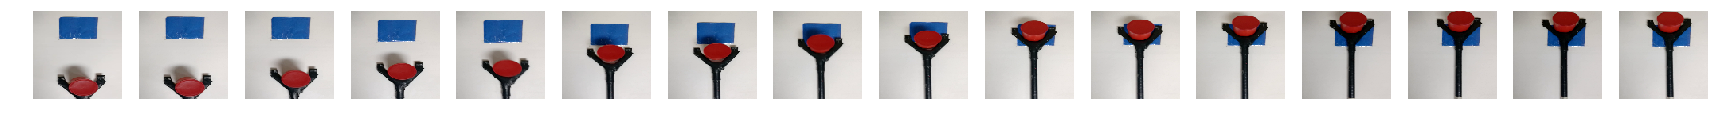

vid.shape (16, 112, 112, 3)
331.624


In [159]:
## Comp2
activitynet_features=(activity_feature_extractor('push_robo_comp1')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_comp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


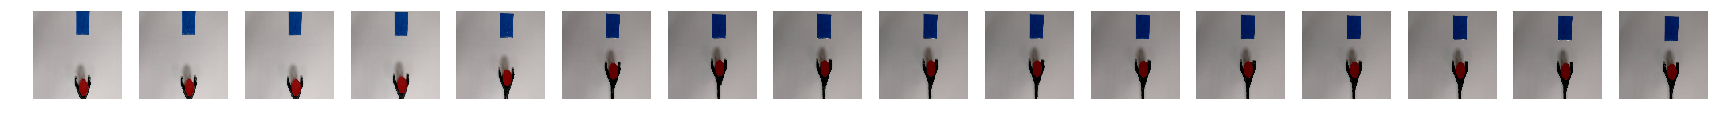

vid.shape (16, 112, 112, 3)
343.044


In [160]:
## Partially incomplete: along straight line
activitynet_features=(activity_feature_extractor('push_robo_incomp')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_incomp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


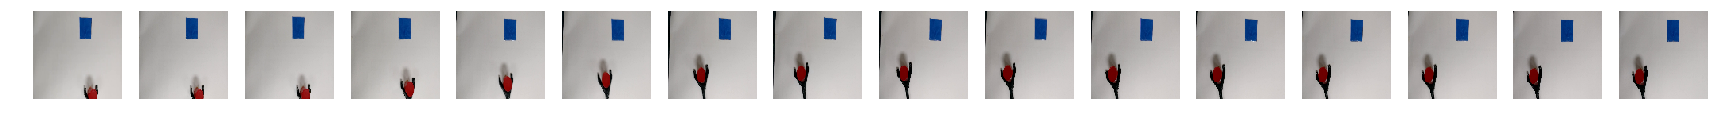

vid.shape (16, 112, 112, 3)
313.425


In [161]:
## Partially incomplete: moving left
activitynet_features=(activity_feature_extractor('push_robo_left')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_incomp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


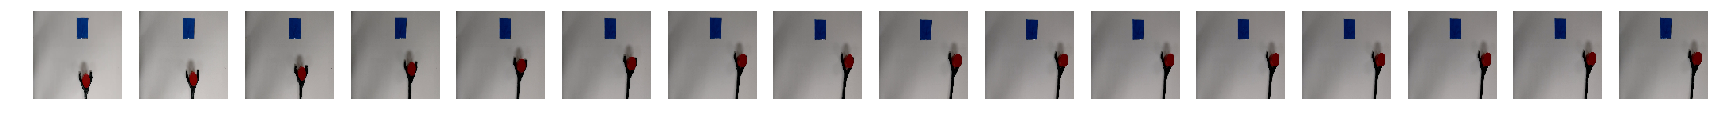

vid.shape (16, 112, 112, 3)
271.04


In [162]:
## Partially incomplete: moving right
activitynet_features=(activity_feature_extractor('push_robo_right')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_incomp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


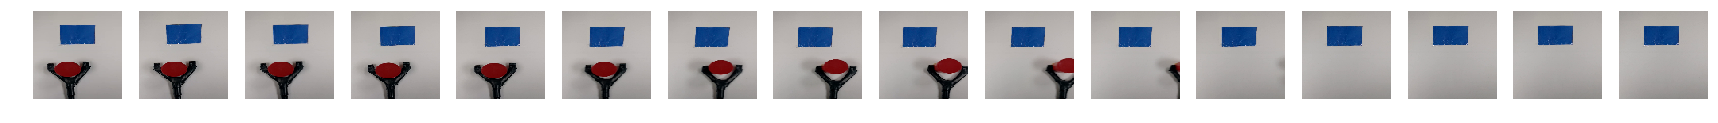

vid.shape (16, 112, 112, 3)
229.71


In [163]:
## Partially incomplete: out of scene
activitynet_features=(activity_feature_extractor('push_robo_out_new')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_incomp.append(distance)

Is the folder present: True
ret_arr (16, 112, 112, 3)
Obtained video shape (16, 112, 112, 3)


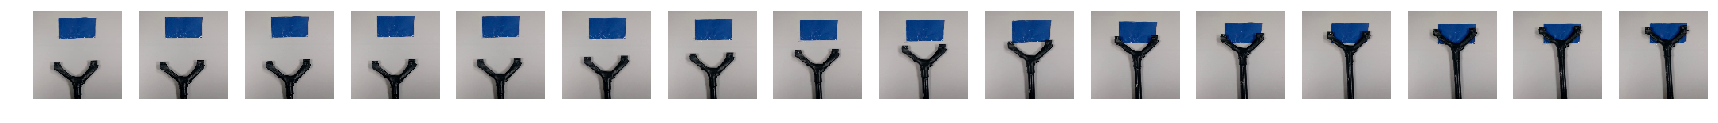

vid.shape (16, 112, 112, 3)
265.933


In [164]:
## Miscellenours
activitynet_features=(activity_feature_extractor('push_robo_misc')) 
distance=np.linalg.norm(activitynet_features_demo-activitynet_features)
print(distance)
distance_incomp.append(distance)

In [165]:
distance_comp=np.array(distance_comp)
distance_incomp=np.array(distance_incomp)

distance_comp_avg=sum(distance_comp)/len(distance_comp)
distance_incomp_avg=sum(distance_incomp)/len(distance_incomp)
ratio_compvsincomp=distance_comp_avg/distance_incomp_avg

print('Ratio bw distance_comp to distance_incomp:',round(ratio_compvsincomp,4))

Ratio bw distance_comp to distance_incomp: 1.1473


In [166]:
demo_num=demo_num+1